# Evaluating a CellPose2 model

In this notebook, we will take predictions from our model_training notebook to compare with the ground truth data to showcase how to evaluate how a cell segmenting model performs.

Our data is pictures of cells and masks. The masks each segment multiple cells of the images and give each cell its own color code

## Individually segmenting out the cells

This process follows the following method:
    &nbsp;&nbsp;&nbsp;&nbsp;get the pixel values that are in the predicted mask (0 is the background)
    &nbsp;&nbsp;&nbsp;&nbsp;for each pixel value
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;get its 4 corners
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;calculate its longest diagonal
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;use it to create a bounding box around the cell
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;store the coordinates of that bounding box
    &nbsp;&nbsp;&nbsp;&nbsp;apply all of the bounding boxes around the original image to see if it retrieves the nuclei

In [1]:
#Load the model and data
from cellpose import models, io, metrics
model = models.CellposeModel(gpu=True,
                             pretrained_model='C:/Users/rz200/Documents/Development/cell-SCT/segmentation/demo_train_test_data/data_for_masks_training/models/demo_model')
train_dir = "C:/Users/rz200/Documents/Development/cell-SCT/segmentation/demo_train_test_data/data_for_masks_training"
test_dir = "C:/Users/rz200/Documents/Development/cell-SCT/segmentation/demo_train_test_data/data_for_masks_testing"

In [2]:

#I need to add comments to this
channels = [0,0] #first 0: grayscale; second 0: None
diam_labels = model.diam_labels.copy() #diameter of labels in training images
output = io.load_train_test_data(test_dir, mask_filter='_seg.npy')
test_data, test_labels = output[:2]
predicted_test_masks = model.eval(test_data,
                                  channels=channels,
                                  diameter=diam_labels)[0]

#Checking the performance
ap = metrics.average_precision(test_labels, predicted_test_masks)[0]
print('')
print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')


>>> average precision at iou threshold 0.5 = 0.823


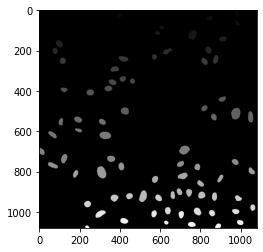

In [20]:
import matplotlib.pyplot as plt

plt.imshow(predicted_test_masks[0],cmap='gray')

In [31]:
import crop_cells
import importlib
importlib.reload(crop_cells)

<module 'crop_cells' from 'C:\\Users\\rz200\\Documents\\Development\\cell-SCT\\segmentation\\crop_cells.py'>

In [32]:
from crop_cells import get_img_crops
crops_test = get_img_crops(predicted_test_masks[0])

In [39]:
#Get the crops of the groundtruth and the crops of the prediction, both of the first mask of the test images
#this is code we'll later on want to add to crop_cells or some other python file to keep this notebook clean
import numpy as np
pred = np.copy(predicted_test_masks[0])
gt = np.copy(test_labels[0])

#So actually, I changed get_img_crops to just take the image and get the coordinates from there instead of having to input your own coordinates
#This is a mistake because we would want the coordinates to be found from the mask and then applied to a different image
#This needs to be fixed
pred_crops = get_img_crops(pred)
gt_crops = get_img_crops(gt)


#Use the iou mathcing CellPose method to match them together and display all of them next to each other with their index

In [80]:
print(test_labels[0])
print(gt[0])
print(len(test_labels))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[0 0 0 ... 0 0 0]
5


In [91]:
print(gt_crops[3])

[[87 87 87 ...  0  0  0]
 [87 87 87 ...  0  0  0]
 [87 87 87 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


In [94]:
#match up the crops
from cellpose import metrics
ious = metrics.mask_ious(gt,pred)
#print(ious)

#in this following list, each element corresponds to the predicted masks cells in order and their number is the one that they match up to in the predictions
#if the first element is 12, the first crop of the groundtruth corresponds to the 11th (12-1, counting from 0) crop from the prediction
index_match_gt_to_pred = ious[1]
print(index_match_gt_to_pred)
pairs = []
for i in range(len(index_match_gt_to_pred)):
    print(i)
    print(gt_crops[i])
    new_pair = (gt_crops[i],pred_crops[index_match_gt_to_pred[i]-1])
    pairs.append(new_pair)

[ 1  2  3  0  4  5  7  9 10 11 12 13 14 15 16 17 19 18 20 21  0 22 23 24
 25  0  0 26 27 28 29 30  0 32 31 33 34 35 36 37 38 39 40 41 42 43 44 45
 46 48 49  0 51 52 53 54 55 56 57 58 59 60 61 63 62 64 65 66 67 68 69 70
 71 72 73 74 75 76 79 47 78 77  6  8  0 50  0]
0
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
1
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
2
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
3
[[87 87 87 ...  0  0  0]
 [87 87 87 ...  0  0  0]
 [87 87 87 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
4
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
5
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0

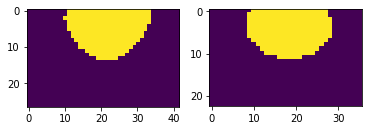

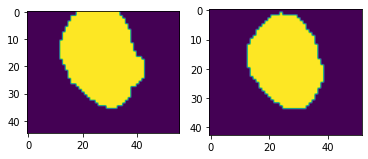

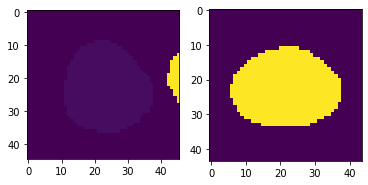

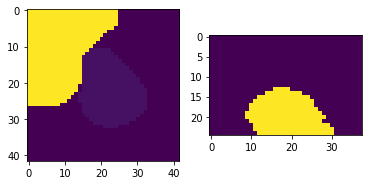

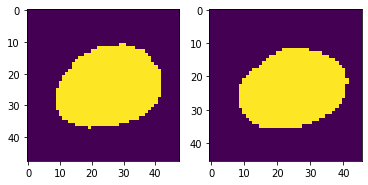

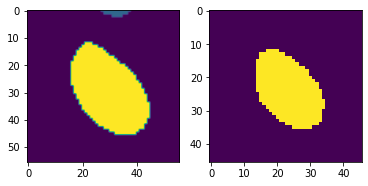

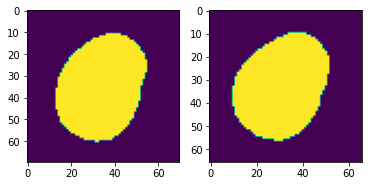

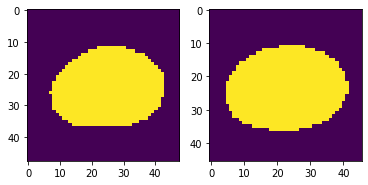

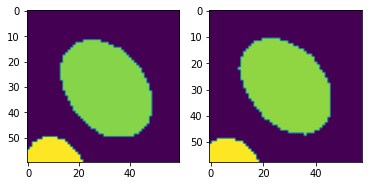

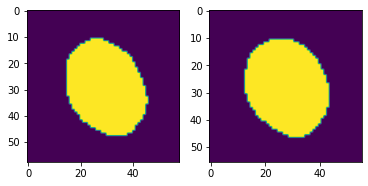

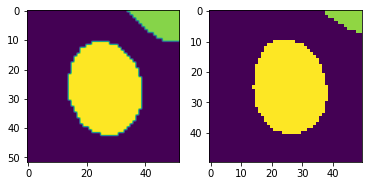

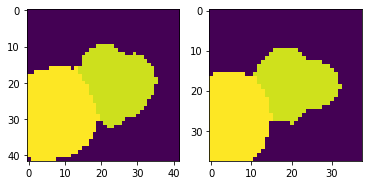

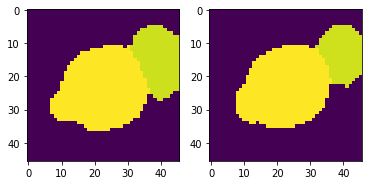

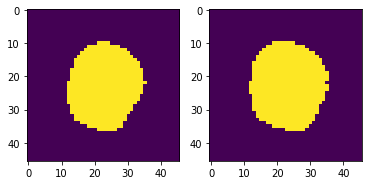

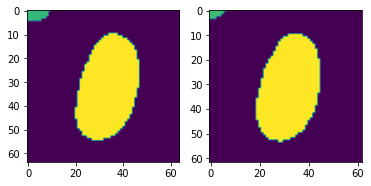

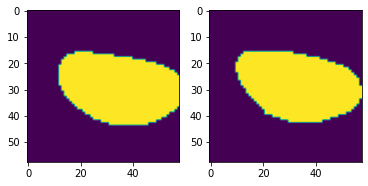

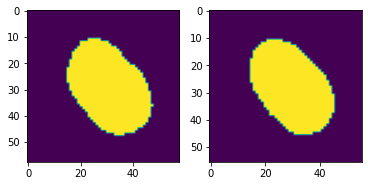

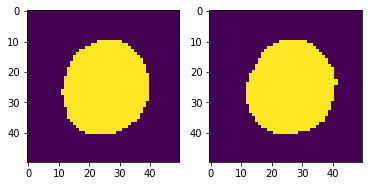

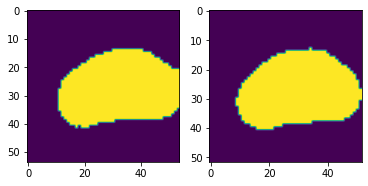

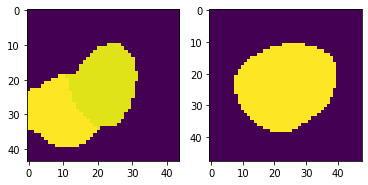

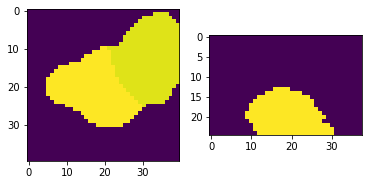

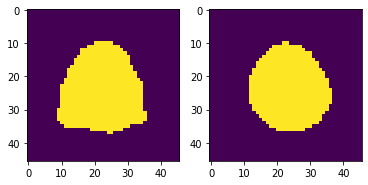

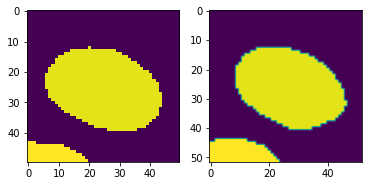

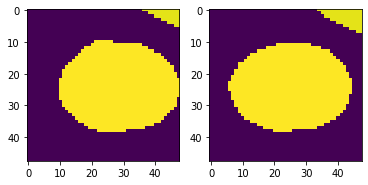

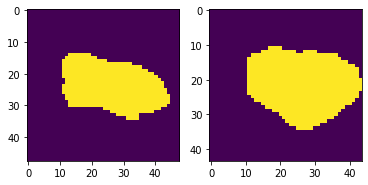

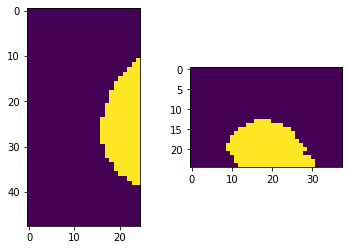

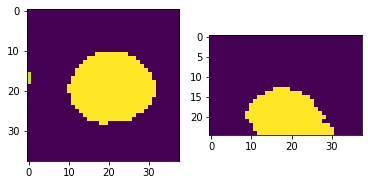

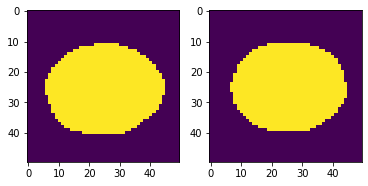

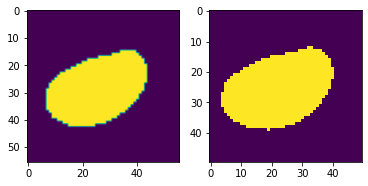

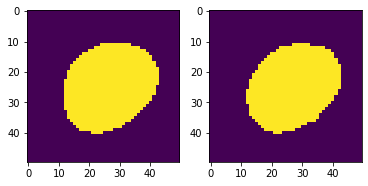

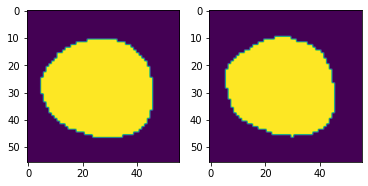

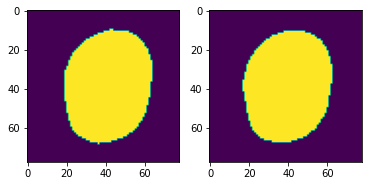

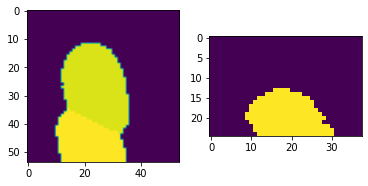

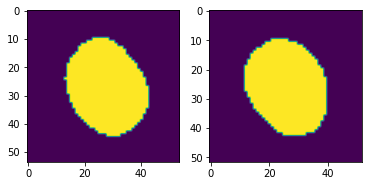

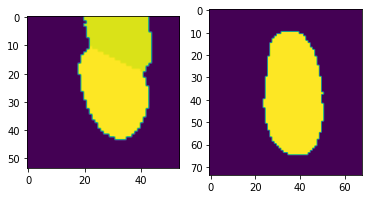

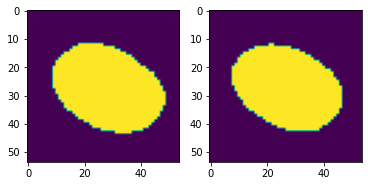

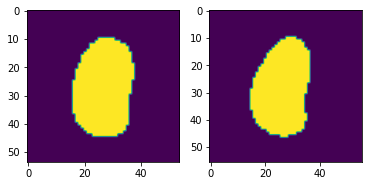

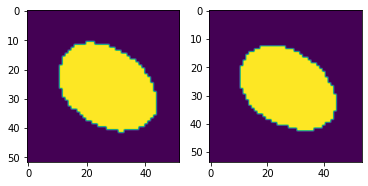

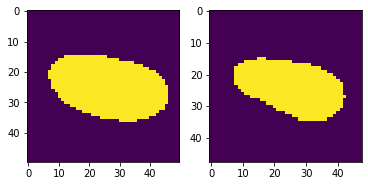

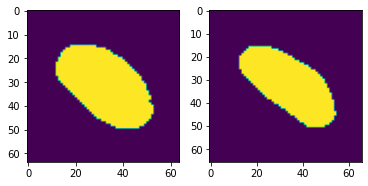

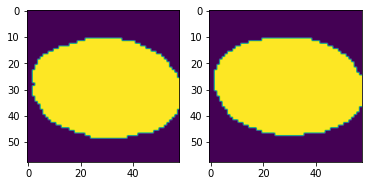

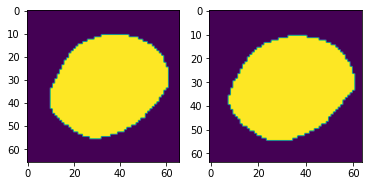

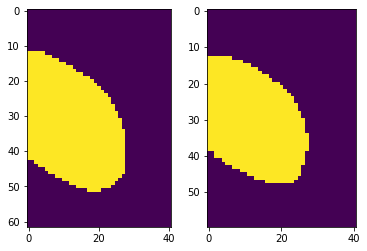

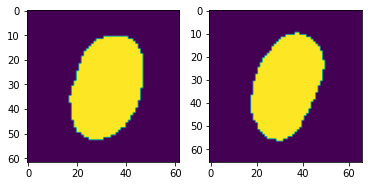

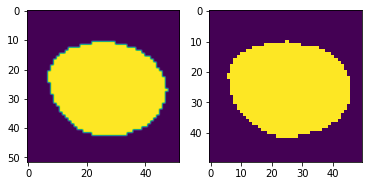

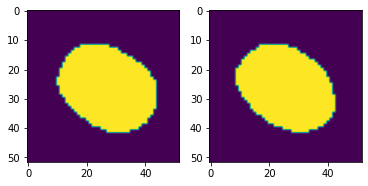

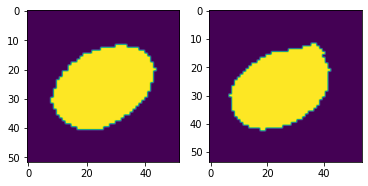

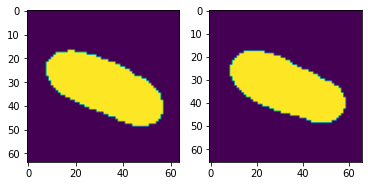

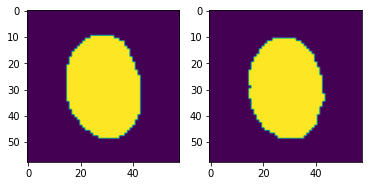

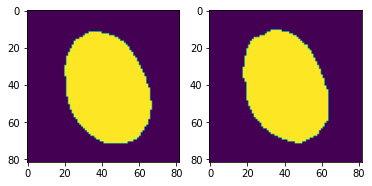

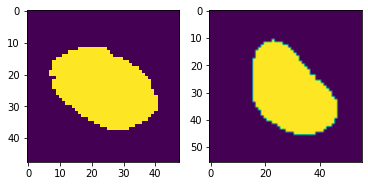

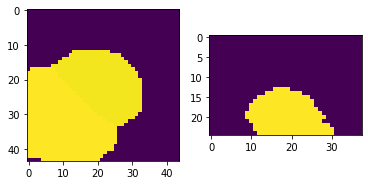

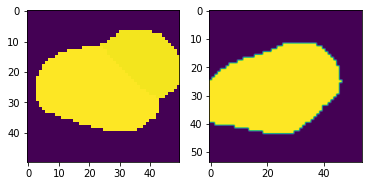

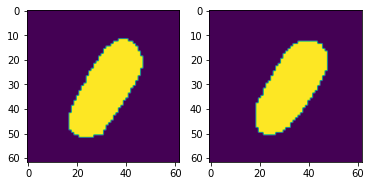

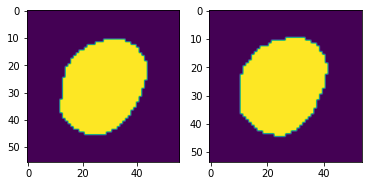

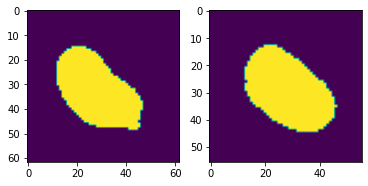

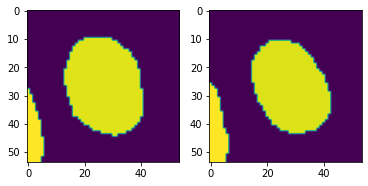

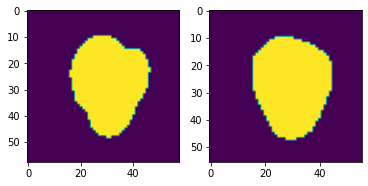

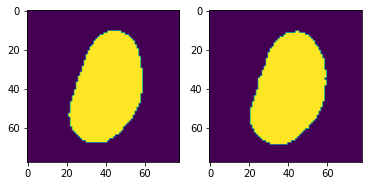

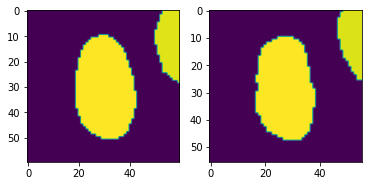

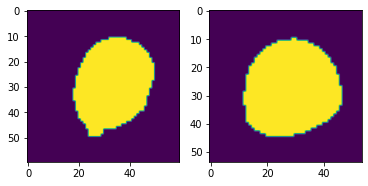

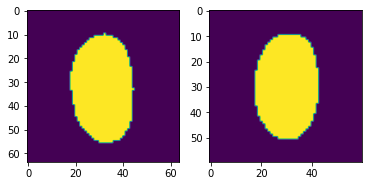

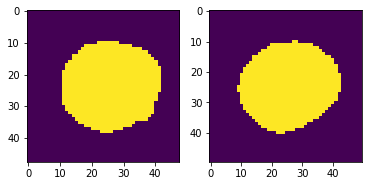

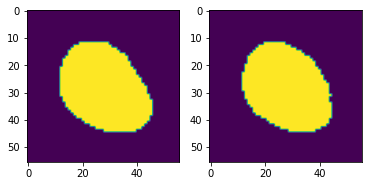

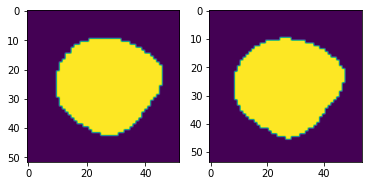

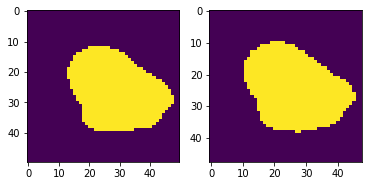

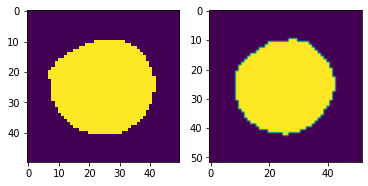

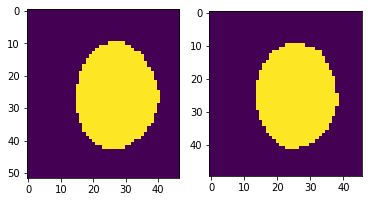

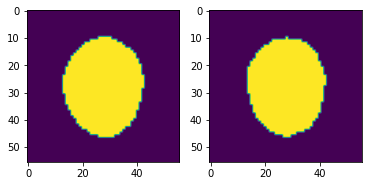

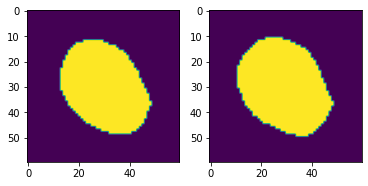

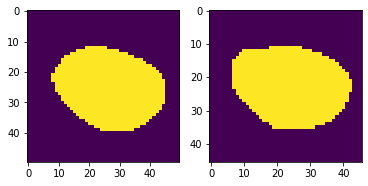

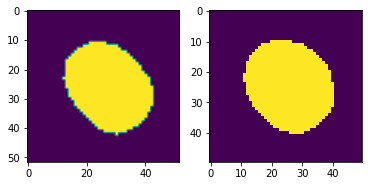

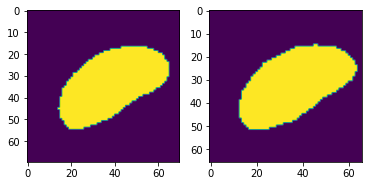

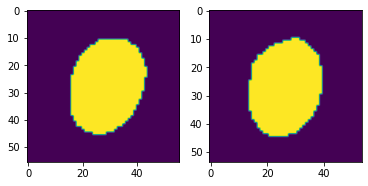

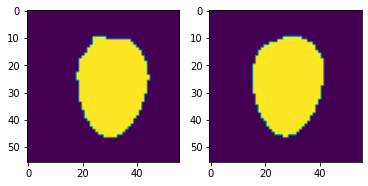

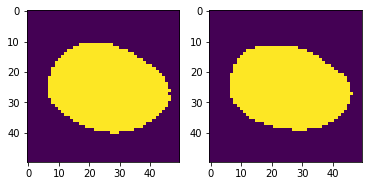

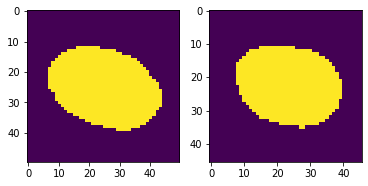

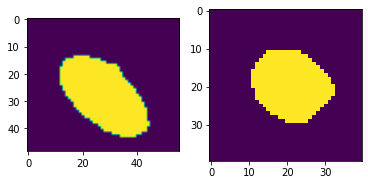

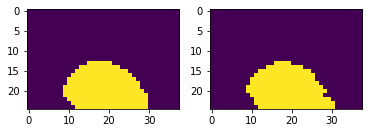

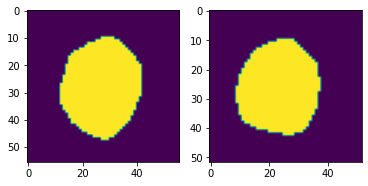

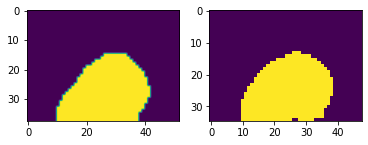

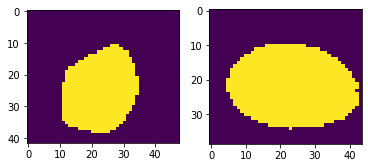

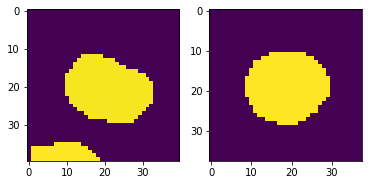

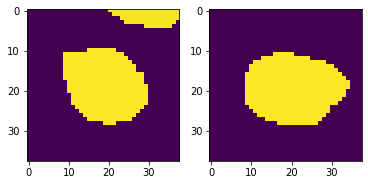

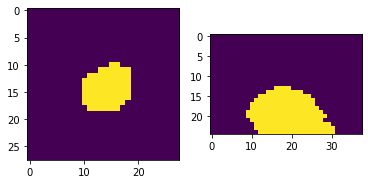

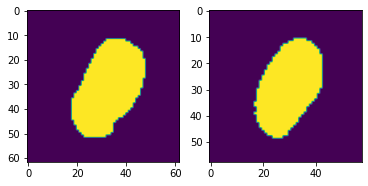

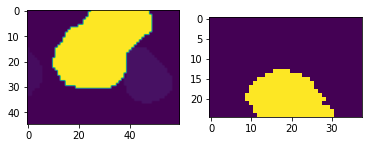

In [96]:
for pair in pairs:
    plt.subplot(121)
    plt.imshow(pair[0])
    plt.subplot(122)
    plt.imshow(pair[1])
    plt.show()

#Ok this is good but I should get these crops to be made on the real cell image, not the masks